In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (accuracy_score, confusion_matrix, classification_report,
                             roc_auc_score, roc_curve, RocCurveDisplay)

In [3]:
df = pd.read_csv('heart-disease.csv') 

In [4]:
print(df.shape)
print(df.columns)
print(df["target"].value_counts())

(303, 14)
Index(['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach',
       'exang', 'oldpeak', 'slope', 'ca', 'thal', 'target'],
      dtype='object')
target
1    165
0    138
Name: count, dtype: int64


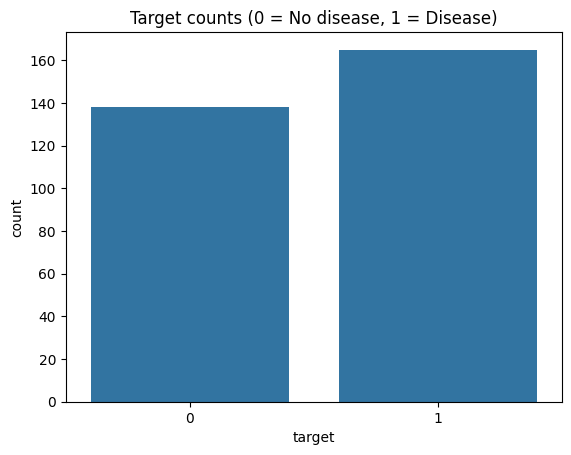

In [5]:
sns.countplot(x="target", data=df)
plt.title("Target counts (0 = No disease, 1 = Disease)")
plt.show()


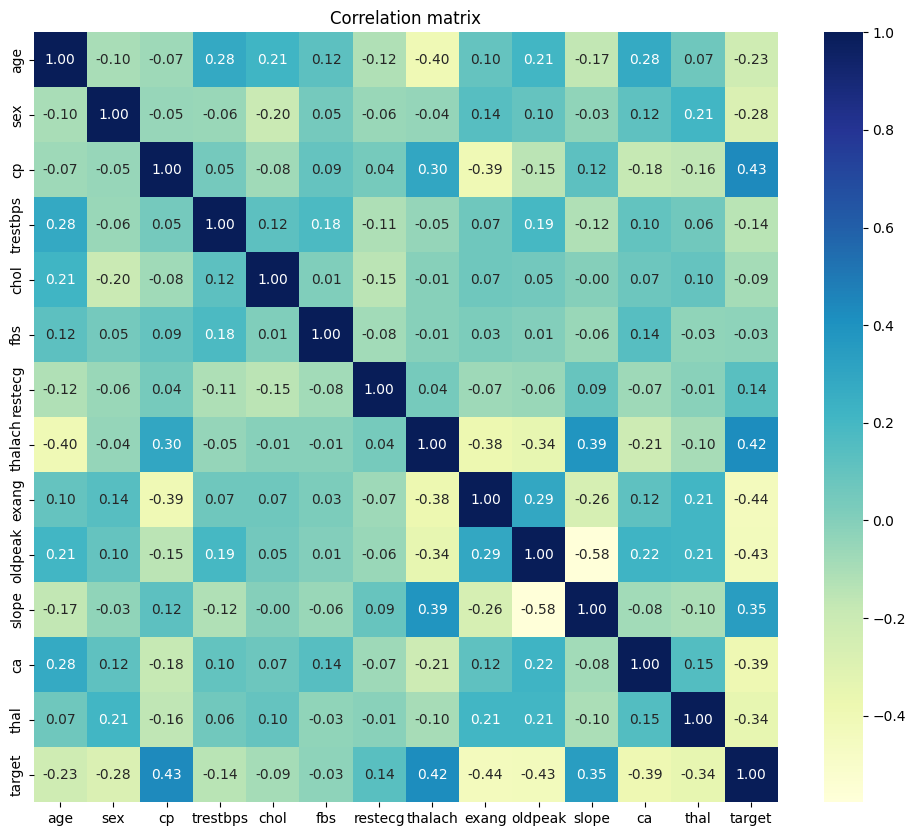

In [6]:
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(), annot=True, fmt=".2f", cmap="YlGnBu")
plt.title("Correlation matrix")
plt.show()

In [8]:
df = df[["cp", "thalach", "oldpeak", "slope", "ca", "thal", "exang", "target"]]

In [10]:
X = df.drop("target", axis=1)
y = df["target"]

In [11]:
feature_names = X.columns.tolist()
print("Features:", feature_names)

Features: ['cp', 'thalach', 'oldpeak', 'slope', 'ca', 'thal', 'exang']


In [12]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)


In [13]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [14]:
joblib.dump(scaler, "scaler.joblib")

['scaler.joblib']

In [15]:
models = {
    "LogisticRegression": LogisticRegression(solver="liblinear", random_state=42),
    "KNN": KNeighborsClassifier(),
    "RandomForest": RandomForestClassifier(random_state=42)
}

LogisticRegression (baseline) - Accuracy: 0.7705, AUC: 0.8528
              precision    recall  f1-score   support

           0       0.82      0.64      0.72        28
           1       0.74      0.88      0.81        33

    accuracy                           0.77        61
   macro avg       0.78      0.76      0.76        61
weighted avg       0.78      0.77      0.77        61



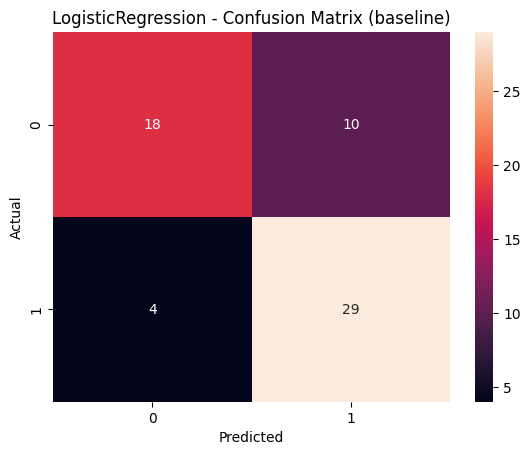

KNN (baseline) - Accuracy: 0.8197, AUC: 0.8842
              precision    recall  f1-score   support

           0       0.87      0.71      0.78        28
           1       0.79      0.91      0.85        33

    accuracy                           0.82        61
   macro avg       0.83      0.81      0.81        61
weighted avg       0.83      0.82      0.82        61



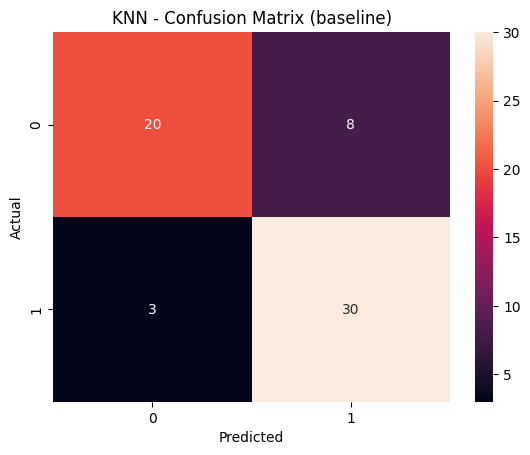

RandomForest (baseline) - Accuracy: 0.8361, AUC: 0.9372
              precision    recall  f1-score   support

           0       0.95      0.68      0.79        28
           1       0.78      0.97      0.86        33

    accuracy                           0.84        61
   macro avg       0.87      0.82      0.83        61
weighted avg       0.86      0.84      0.83        61



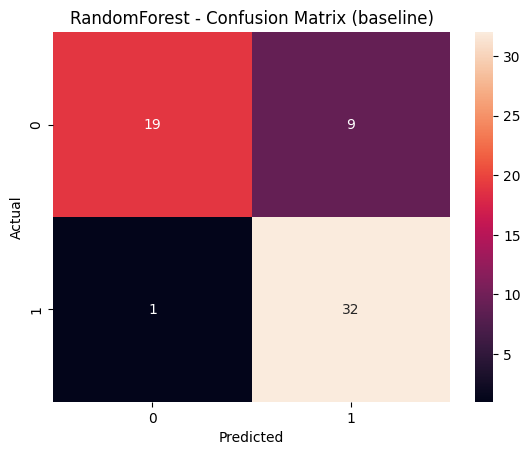

In [17]:
results = {}
for name, model in models.items():
    if name == "RandomForest":
        # RF doesn't need scaled features (but it's okay to use scaled)
        model.fit(X_train, y_train)
        preds = model.predict(X_test)
        probs = model.predict_proba(X_test)[:, 1]
    else:
        # For LR and KNN use scaled features
        model.fit(X_train_scaled, y_train)
        preds = model.predict(X_test_scaled)
        probs = model.predict_proba(X_test_scaled)[:, 1]

    acc = accuracy_score(y_test, preds)
    auc = roc_auc_score(y_test, probs)
    results[name] = {"accuracy": acc, "auc": auc, "model": model}
    print(f"{name} (baseline) - Accuracy: {acc:.4f}, AUC: {auc:.4f}")
    print(classification_report(y_test, preds))
    cm = confusion_matrix(y_test, preds)
    sns.heatmap(cm, annot=True, fmt="d")
    plt.title(f"{name} - Confusion Matrix (baseline)")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

In [18]:
for name, entry in results.items():
    clf = entry["model"]
    if name == "RandomForest":
        scores = cross_val_score(clf, X, y, cv=5, scoring="accuracy")
    else:
        # cross_val_score expects full data; use pipeline or scaled array
        # We'll scale X here for fair comparison for LR & KNN:
        scores = cross_val_score(clf, scaler.transform(X), y, cv=5, scoring="accuracy")
    print(f"{name} CV Accuracy (mean): {scores.mean():.4f} (std {scores.std():.4f})")

LogisticRegression CV Accuracy (mean): 0.8413 (std 0.0551)
KNN CV Accuracy (mean): 0.8448 (std 0.0325)
RandomForest CV Accuracy (mean): 0.8051 (std 0.0579)


In [20]:
np.random.seed(42)

rf = RandomForestClassifier(random_state=42)
rf_param_dist = {
    "n_estimators": np.arange(50, 501, 50),
    "max_depth": [None, 3, 5, 10, 15],
    "min_samples_split": [2, 4, 6, 8],
    "min_samples_leaf": [1, 2, 4, 8, 12]
}
rs_rf = RandomizedSearchCV(
    estimator=rf,
    param_distributions=rf_param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

In [21]:
rs_rf.fit(X_train, y_train)  # RF can work on unscaled features
print("RandomForest best params:", rs_rf.best_params_)
print("RandomForest best CV AUC:", rs_rf.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
RandomForest best params: {'n_estimators': np.int64(100), 'min_samples_split': 2, 'min_samples_leaf': 12, 'max_depth': 10}
RandomForest best CV AUC: 0.9143097643097644


In [22]:
# Evaluate tuned RF on test set
best_rf = rs_rf.best_estimator_
rf_preds = best_rf.predict(X_test)
rf_probs = best_rf.predict_proba(X_test)[:, 1]
print("Tuned RF - accuracy:", accuracy_score(y_test, rf_preds))
print("Tuned RF - AUC:", roc_auc_score(y_test, rf_probs))
print(classification_report(y_test, rf_preds))

Tuned RF - accuracy: 0.819672131147541
Tuned RF - AUC: 0.9042207792207793
              precision    recall  f1-score   support

           0       0.95      0.64      0.77        28
           1       0.76      0.97      0.85        33

    accuracy                           0.82        61
   macro avg       0.85      0.81      0.81        61
weighted avg       0.85      0.82      0.81        61



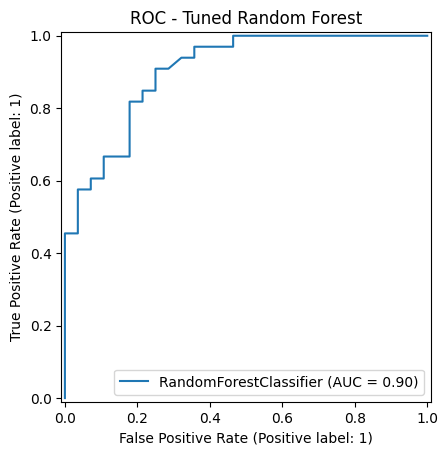

In [23]:
RocCurveDisplay.from_estimator(best_rf, X_test, y_test)
plt.title("ROC - Tuned Random Forest")
plt.show()

In [24]:
lr = LogisticRegression(solver="liblinear", random_state=42, max_iter=1000)
lr_param_dist = {"C": np.logspace(-4, 4, 30), "penalty": ["l1", "l2"]}

rs_lr = RandomizedSearchCV(
    estimator=lr,
    param_distributions=lr_param_dist,
    n_iter=20,
    scoring="roc_auc",
    cv=5,
    random_state=42,
    verbose=1,
    n_jobs=-1
)

In [25]:
rs_lr.fit(X_train_scaled, y_train)
print("LogReg best params:", rs_lr.best_params_)
print("LogReg best CV AUC:", rs_lr.best_score_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
LogReg best params: {'penalty': 'l2', 'C': np.float64(0.01610262027560939)}
LogReg best CV AUC: 0.8982905982905983


Tuned LR - accuracy: 0.7540983606557377
Tuned LR - AUC: 0.854978354978355
              precision    recall  f1-score   support

           0       0.78      0.64      0.71        28
           1       0.74      0.85      0.79        33

    accuracy                           0.75        61
   macro avg       0.76      0.75      0.75        61
weighted avg       0.76      0.75      0.75        61



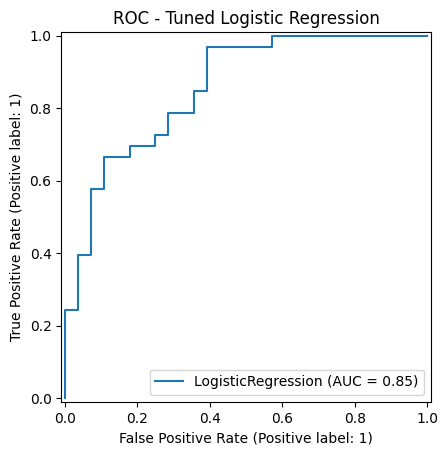

In [26]:
best_lr = rs_lr.best_estimator_
lr_preds = best_lr.predict(X_test_scaled)
lr_probs = best_lr.predict_proba(X_test_scaled)[:, 1]
print("Tuned LR - accuracy:", accuracy_score(y_test, lr_preds))
print("Tuned LR - AUC:", roc_auc_score(y_test, lr_probs))
print(classification_report(y_test, lr_preds))

RocCurveDisplay.from_estimator(best_lr, X_test_scaled, y_test)
plt.title("ROC - Tuned Logistic Regression")
plt.show()

In [27]:
from sklearn.model_selection import GridSearchCV
grid_params = {"C": [rs_lr.best_params_["C"] * factor for factor in [0.5, 1, 2]], "penalty": ["l1", "l2"]}
gs_lr = GridSearchCV(LogisticRegression(solver="liblinear", random_state=42, max_iter=1000),
                     param_grid=grid_params, cv=5, scoring="roc_auc", verbose=1, n_jobs=-1)
gs_lr.fit(X_train_scaled, y_train)
print("GridSearch LR best:", gs_lr.best_params_, "best score:", gs_lr.best_score_)

Fitting 5 folds for each of 6 candidates, totalling 30 fits
GridSearch LR best: {'C': np.float64(0.03220524055121878), 'penalty': 'l2'} best score: 0.8993654493654493


                model     stage  accuracy       auc
0  LogisticRegression  baseline  0.770492  0.852814
1                 KNN  baseline  0.819672  0.884199
2        RandomForest  baseline  0.836066  0.937229
3        RandomForest     tuned  0.819672  0.904221
4  LogisticRegression     tuned  0.754098  0.854978


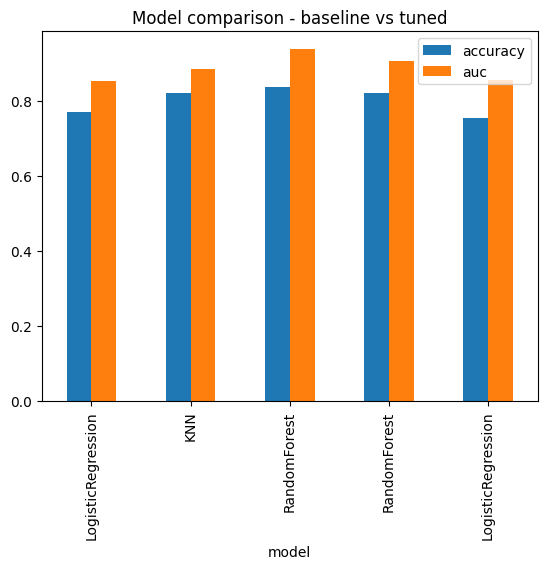

In [32]:
comparison = pd.DataFrame(columns=["model", "stage", "accuracy", "auc"])

row = []
# Baselines
for name in ["LogisticRegression", "KNN", "RandomForest"]:
    acc = results[name]["accuracy"]
    aucv = results[name]["auc"]
    row.append({"model": name, "stage": "baseline", "accuracy": acc, "auc": aucv})

# After tuning
row.append({"model":"RandomForest", "stage":"tuned", "accuracy":accuracy_score(y_test, rf_preds), "auc":roc_auc_score(y_test, rf_probs)})
row.append({"model":"LogisticRegression", "stage":"tuned", "accuracy":accuracy_score(y_test, lr_preds), "auc":roc_auc_score(y_test, lr_probs)})
comparison = pd.concat([pd.DataFrame(row)], ignore_index=True)

print(comparison)
comparison.plot(x="model", y=["accuracy","auc"], kind="bar")
plt.title("Model comparison - baseline vs tuned")
plt.show()

   feature  importance
0       cp    0.238998
5     thal    0.207026
2  oldpeak    0.150449
4       ca    0.119371
6    exang    0.115209
1  thalach    0.110384
3    slope    0.058563


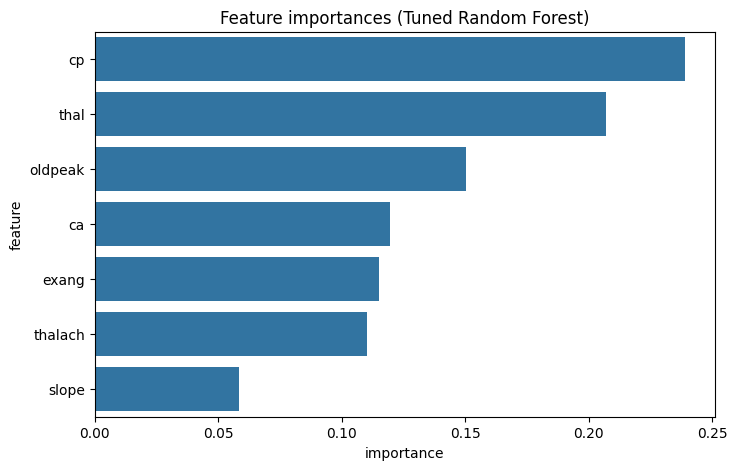

In [33]:
fi = pd.DataFrame({"feature": X.columns, "importance": best_rf.feature_importances_}).sort_values("importance", ascending=False)
print(fi)
plt.figure(figsize=(8,5))
sns.barplot(x="importance", y="feature", data=fi)
plt.title("Feature importances (Tuned Random Forest)")
plt.show()

   feature      coef
0       cp  0.350274
5     thal -0.277706
6    exang -0.274967
2  oldpeak -0.273393
4       ca -0.253997
1  thalach  0.230384
3    slope  0.201997


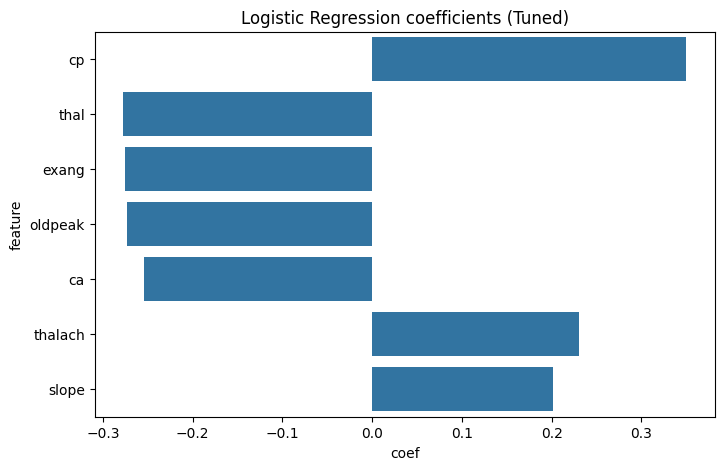

In [34]:
# Logistic regression coefficients (if using scaled X)
coef_df = pd.DataFrame({"feature": X.columns, "coef": best_lr.coef_[0]}).sort_values("coef", key=lambda s: s.abs(), ascending=False)
print(coef_df)
plt.figure(figsize=(8,5))
sns.barplot(x="coef", y="feature", data=coef_df)
plt.title("Logistic Regression coefficients (Tuned)")
plt.show()

In [35]:
final_model = best_rf
joblib.dump(final_model, "model/heart_disease_model.pkl")
print("Saved model to model/heart_disease_model.pkl")

Saved model to model/heart_disease_model.pkl


In [36]:
joblib.dump(scaler, "model/scaler.joblib")
pd.Series(feature_names).to_csv("model/feature_order.txt", index=False)
print("Saved scaler and feature order")

Saved scaler and feature order
